## Exercices de découverte du PMSI MCO (Version Python)
Dans ce script, je cherche les différentes opérations d'extraction de tumeurs, les dates d'opérations et les lieux.
On les décompte ensuite au moyen d'un diagramme.

In [ ]:
 # Chargement des modules

import pandas as pd   

 Importons maintenant les données synthétiques sur lesquelles nous allons exécuter les exercices./!\ Attention, les données synthétiques ne limitent pas les données d'une table à une période temporelle donnée. Cela est toutefois le cas dans le SNDS où la plupart des tables du PMSI sont annuelles.

In [ ]:
from google.colab import drive
drive.mount('/drive')


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Récupération des fichiers de données depuis Gitlab
drive_dir = '/drive/MyDrive'
data_dir = drive_dir + '/snds_&_covid/snds/'

In [ ]:
# Chemins d'accès aux fichiers
df_mco_b = pd.read_csv(data_dir + "T_MCOaa_nnB.csv", header=0, sep=",")         # Description du séjour
df_mco_a = pd.read_csv(data_dir + "T_MCOaa_nnA.csv", header=0, sep=",")         # Actes CCAM
df_mco_c = pd.read_csv(data_dir + "T_MCOaa_nnC.csv", header=0, sep=",")         # NIR patient et date soin
df_mco_d = pd.read_csv(data_dir + "T_MCOaa_nnD.csv", header=0, sep=",")         # Diagnostique associé
df_mco_e = pd.read_csv(data_dir + "T_MCOaa_nnE.csv", header=0, sep=",")         # Etablissment
df_mco_fb = pd.read_csv(data_dir + "T_MCOaa_nnFB.csv", header=0, sep=",")       # Prestations Objectifs Quantifiés Nationaux
df_mco_fbstc = pd.read_csv(data_dir + "T_MCOaa_nnFBSTC.csv", header=0, sep=",") # Prestations Actes et Consultations Externes

# Création de la variable sejour unique (couple ETA_NUM, RSA_NUM)
df_mco_b["ETA_NUM_RSA_NUM"] = df_mco_b["ETA_NUM"].astype(str) + "_" + df_mco_b["RSA_NUM"].astype(str)
df_mco_a["ETA_NUM_RSA_NUM"] = df_mco_a["ETA_NUM"].astype(str) + "_" +  df_mco_a["RSA_NUM"].astype(str)
df_mco_c["ETA_NUM_RSA_NUM"] = df_mco_c["ETA_NUM"].astype(str) + "_" + df_mco_c["RSA_NUM"].astype(str)
df_mco_d["ETA_NUM_RSA_NUM"] = df_mco_d["ETA_NUM"].astype(str) + "_" +  df_mco_d["RSA_NUM"].astype(str)

In [ ]:
df_mco_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 96 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       5000 non-null   int64  
 1   AGE_ANN          5000 non-null   int64  
 2   AGE_GES          5000 non-null   int64  
 3   AGE_JOU          5000 non-null   int64  
 4   ANT_SUP_NBR      5000 non-null   int64  
 5   AUT_PGV_NBR      5000 non-null   int64  
 6   BDI_COD          5000 non-null   object 
 7   BDI_DEP          5000 non-null   object 
 8   BEB_SEJ          2544 non-null   object 
 9   BEH_NBJ          5000 non-null   int64  
 10  CAI_SUP_NBR      5000 non-null   int64  
 11  COD_SEX          5000 non-null   int64  
 12  DEL_REG_ENT      5000 non-null   int64  
 13  DGN_PAL          5000 non-null   object 
 14  DGN_REL          5000 non-null   object 
 15  DOS_TYP          5000 non-null   int64  
 16  ENT_MOD          5000 non-null   int64  
 17  ENT_PRV       

 Dans le SNDS, des nettoyages sont nécessaires pour la bonne exploitation des données. Au niveau du champ MCO du PMSI, l'un d'entre eux consiste à supprimer les doublons au niveau de certains établissements de soins grâce à leur numéro FINESS. En effet, pour l’APHP (Assistance Publique - Hôpitaux de Paris), les HCL (Hospices Civils de Lyon) et l’APHM (Hôpitaux Universitaires de Marseille), les établissements sont présents à la fois sous leur code FINESS géographique et juridique (jusqu’en 2018). Afin de ne pas les compter en double, il faut supprimer un certain nombre de codes grâce à la variable ETA_NUM renseignant le code FINESS des établissements. Vous trouverez ci-dessous un vecteur eta_num_supr avec les codes ETA_NUM à supprimer lorsqu'on travaille sur le PMSI (cf. Fiche Dépenses des établissements de santé publics dans le PMSI).

In [ ]:
ETA_NUM_doubles = [
'130780521','130783236', '130783293', '130784234', '130804297', '600100101','750041543', '750100018',
'750100042', '750100075', '750100083', '750100091', '750100109', '750100125','750100166', '750100208', 
'750100216', '750100232', '750100273', '750100299', '750801441', '750803447','750803454', '910100015', 
'910100023', '920100013', '920100021', '920100039', '920100047', '920100054','920100062', '930100011', 
'930100037', '930100045', '940100027', '940100035', '940100043', '940100050','940100068', '950100016', 
'690783154', '690784137', '690784152', '690784178', '690787478', '830100558' 
]

## Exercice 1 : Nombre de séjours hospitaliers par établissement
Dans cet exercice, nous allons calculer le nombre de séjours hospitaliers par établissement l'année aa. L'exercice fait donc appel à la table des séjours T_MCOaaB. Un séjour hospitalier est identifié par le couple de variables ETA_NUM (numéro FINESS de l'établissement) - RSA_NUM (numéro séquentiel du résumé de sortie anonyme). Comme évoqué, à coté de la suppression des séjours en double pour l'APHP, l'AP-HM et les HCL (filtre ~ df_mco_b.index.get_level_values(0).isin(ETA_NUM_doubles)), il faut aussi penser à supprimer les séjours en erreur (filtre df_mco_b["GRG_GHM"].str[0:2] != "90").

In [ ]:
filtres_mco_b = (
    (df_mco_b["GRG_GHM"].str[0:2] != "90")         # Suppression des séjours en erreur
    &
    (~
     df_mco_b.index.get_level_values(0)            # Suppression des séjours en double APHP, HCL, AP-HM
     .isin(ETA_NUM_doubles))                      
)

In [ ]:
sej_par_etab = df_mco_b[filtres_mco_b].groupby('ETA_NUM')['RSA_NUM'].nunique() # Calcul du nombre de séjours par établissement
sej_par_etab = sej_par_etab.reset_index(name='NB_SEJ')
sej_par_etab.head(5)   

,ETA_NUM,NB_SEJ
0,101562418,19
1,103942560,18
2,108502982,15
3,110914559,16
4,111826119,30


## Exercice 2 : Identifier le nombre d'actes médicaux exécutés par établissement pour un acte spécifique - Exemple de l'exérèse du pancreas HNFA005
Dans cet exercice, nous allons comptabiliser le nombre d'actes exécutés lors de séjours hospitaliers pour un acte spécifique par établissement l'année aa. Un acte médical dans le SNDS est classifié suivant la Classification Commune des Actes Médicaux CCAM. L'exercice fait appel à la table des actes T_MCOaaA. Il faudra penser à supprimer les actes associés à des séjours en erreur (filtres des exercices précédents) qu'on repèrera dans la table des séjours T_MCOaaB. Il faut également supprimer les séjours en double APHP, HCL, AP-HM grâce à la variable ETA_NUM (variable présente dans T_MCOaaA).Commençons tout d'abord par chercher dans la nomenclature IR_CCAM_V54, le code CCAM de l'acte qu'on cherche à étudier. Vous pouvez trouver les différentes nomenclatures dans le dictionnaire SNDS au niveau de l'onglet "Recherche dans les nomenclatures" et effectuer une recherche par mots clés par exemple. Ici, focalisons-nous sur l'exérèse de lésion du tronc cérébral par craniotomie, qui correspond au code CCAM "AAFA003". Nous allons repérer les établissements ayant exécuté cet acte l'année aa et le nombre d'actes effectués.

In [ ]:
#filtre de suppression des enregistrements en erreurs et des dublons
filtres_mco_a = (
    (df_mco_a["ETA_NUM_RSA_NUM"]
    .isin(df_mco_b.loc[filtres_mco_b,"ETA_NUM_RSA_NUM"])) # Suppression des séjours en erreur 
    &
    (~
     df_mco_a.index.get_level_values(0)                   # Suppression des séjours en double APHP, HCL, AP-HM
     .isin(ETA_NUM_doubles)) 
)
 

In [ ]:
# Sejours par operation
sej_par_operations = df_mco_a[filtres_mco_a].groupby('CDC_ACT')['RSA_NUM'].nunique() # Calcul du nombre de séjours par établissement
sej_par_operations = sej_par_operations.reset_index(name='NB_SEJ')
sej_par_operations.head(5)   

,CDC_ACT,NB_SEJ
0,AAFA001,24
1,AAFA002,25
2,AAFA003,25
3,AAFA004,21
4,AAFA005,16


In [ ]:
l_cdc_act = sej_par_operations['CDC_ACT'].unique()
len(l_cdc_act)

251

In [ ]:
#On garde uniquement les 100 premières opérations
l_operations = l_cdc_act[:100]

In [ ]:
df_mco_a_sample = df_mco_a.loc[df_mco_a['CDC_ACT'].isin(l_operations)]

Exploration de la table des etablissements T_MCOaaE.
Denombrement des etablissements

In [ ]:
l_eta_distinct = df_mco_e['ETA_NUM'].unique()

In [ ]:
len(l_eta_distinct)

5000

Il y a donc 5000 établissement dans la table mais combien apparaissent dans la table df_mco_a_sample

In [ ]:
l_eta_distinct_mco_a = df_mco_a_sample['ETA_NUM'].unique()
len(l_eta_distinct_mco_a)

152

On modifie la table mco_e pour que le premier chiffre renvoie à une région identifiée par la liste

In [ ]:
l_regions=['CORSICA','BRETAGNE','ILE_DE_FRANCE','HAUTS_DE_FRANCE','ALSACE_FRANCHE_COMTE','NORMANDIE','AQUITAINE','OCCITANIE','BOURGOGNE', 'OUTRE-MER']


In [ ]:
df_mco_e['REG_ETA'] = df_mco_e['ETA_NUM'].apply(lambda x: l_regions[x%10])
df_mco_e['REG_ETA'].head(10)

0                 CORSICA
1               OUTRE-MER
2               OCCITANIE
3               NORMANDIE
4                BRETAGNE
5           ILE_DE_FRANCE
6               AQUITAINE
7               OCCITANIE
8               OCCITANIE
9    ALSACE_FRANCHE_COMTE
Name: REG_ETA, dtype: object

Recherche des dates dans la table mco_c

In [ ]:
df_mco_c.head()

,Unnamed: 0,COH_NAI_RET,COH_SEX_RET,DAT_RET,ENT_DAT,ETA_NUM,ETA_NUM_RET,EXE_SOI_AMD,EXE_SOI_AMF,EXE_SOI_DTD,EXE_SOI_DTF,FHO_RET,FOR_NUM,HOS_NN_MAM,HOS_NNE_RET,HOS_ORG_RET,HOS_PLO,NAI_RET,NIR_ANO_17,NIR_ANO_MAM,NIR_RET,NUM_DAT_AT,NUM_DAT_AT_RET,ORG_CPL_NUM,ORG_CPL_NUM_RET,PMS_RET,RNG_BEN,RNG_BEN_RET,RNG_NAI,RNG_NAI_RET,RSA_NUM,SEJ_MER_RET,SEJ_NUM,SEJ_RET,SEX_RET,SOR_ANN,SOR_DAT,SOR_MOI,VID_HOSP_FOR,ENT_AM,SOR_AM,ETA_NUM_RSA_NUM
0,0,0,1,0,11041902,947955048,1,196405,198711,02Jan2007:22:12:17,25Jan2010:05:23:10,1,11,1,1,1,1,1,XGxgHdphPZsTGNjDN,JOuZZvSuwDbvlinZkeSsGawOvzFfjBbl,1,331674924,0,ssDGoC,1,0,VGS,1,6,0,5749027190,1,96934,0,0,1940,28062019,4,443,196711,194603,947955048_5749027190
1,1,0,0,0,28112015,396674677,0,192909,190510,26May1903:03:12:57,14Dec1972:06:17:33,0,12,0,0,1,1,1,nEjCqweipLmGexefS,NFBTROmzFwuntcerwgbNzeUziFnhxVAP,1,728129931,1,DeJ,0,0,EqU,1,2,1,1503236448,1,79550,9,0,2007,28061983,7,289,199012,194405,396674677_1503236448
2,2,0,1,0,13011937,568037653,0,193303,194408,27May1927:19:28:35,19Feb1959:09:27:09,0,10,0,1,1,0,9,oinUqVcSwdniXuEgL,zuxBjYePiBMHLgfjDrUByLrkjoFYRDPj,1,176965079,0,cEHikqVhSN,0,0,xJk,1,8,0,8668148646,0,84122,0,0,1943,26121997,11,174,193502,202105,568037653_8668148646
3,3,0,1,0,14111938,337375617,1,195107,198310,24May1980:21:39:32,13Oct1945:23:15:43,0,11,0,1,1,1,9,LGLdAaWCmdlSLwJKQ,lgQnXXGLrjFXgNhlnASVGrEKCKjqSLyx,0,306702930,1,WSEjdC,1,0,NaN,1,0,1,3444552266,0,56472,9,1,1925,11021918,1,935,198709,201811,337375617_3444552266
4,4,1,1,0,20122002,111826119,0,194901,193612,11Oct1912:17:49:53,29Feb1976:09:29:25,0,11,1,0,1,1,0,DPGTyQBqVWalLLSDJ,knnLNMxvcGKXtyhNrvLCGskaRjVuydsM,0,407822880,1,NaN,0,0,vdg,0,4,1,7684902182,0,51281,0,0,1914,10051911,6,248,201802,200812,111826119_7684902182


realisation des jointures qui permettront d'exploiter les données

In [ ]:
data_act_reg_df = df_mco_a_sample[['ETA_NUM','CDC_ACT', 'ETA_NUM_RSA_NUM']].join(df_mco_e[['ETA_NUM','REG_ETA']], on='ETA_NUM', how='left', rsuffix='_etab')

In [ ]:
data_act_reg_date_df = pd.merge(data_act_reg_df[['CDC_ACT', 'ETA_NUM_RSA_NUM', 'REG_ETA', 'ETA_NUM']], df_mco_c[['ETA_NUM_RSA_NUM','ENT_DAT']],on='ETA_NUM_RSA_NUM', how='left', suffixes=('', '_date') )

In [ ]:
data_0_df = data_act_reg_date_df[['CDC_ACT', 'ETA_NUM_RSA_NUM', 'REG_ETA', 'ENT_DAT', 'ETA_NUM']].copy()

In [ ]:
data_0_df.to_csv(data_dir + '/data_0_df_30082021.csv')

Extraction du mois, affichage de la région

In [ ]:
data_1_df = data_0_df.copy()

In [ ]:
data_1_df['reg_name'] = data_1_df['ETA_NUM'].apply(lambda x: l_regions[x%10])

In [ ]:
data_1_df.head()

,CDC_ACT,ETA_NUM_RSA_NUM,REG_ETA,ENT_DAT,ETA_NUM,reg_name
0,AAJA001,396674677_1503236448,NaN,28112015,396674677,OCCITANIE
1,AAJA001,396674677_1503236448,NaN,25101959,396674677,OCCITANIE
2,AAJA001,396674677_1503236448,NaN,12101908,396674677,OCCITANIE
3,AAJA001,396674677_1503236448,NaN,7011960,396674677,OCCITANIE
4,AAJA001,396674677_1503236448,NaN,13062017,396674677,OCCITANIE


In [ ]:
data_1_df['month'] = data_1_df['ENT_DAT'].apply(lambda x : int(str(x)[-6:-4]))
data_1_df['day'] = data_1_df['ENT_DAT'].apply(lambda x : int(str(x)[:-6]))

In [ ]:
data_1_df.head()

,CDC_ACT,ETA_NUM_RSA_NUM,REG_ETA,ENT_DAT,ETA_NUM,reg_name,month,day
0,AAJA001,396674677_1503236448,NaN,28112015,396674677,OCCITANIE,11,28
1,AAJA001,396674677_1503236448,NaN,25101959,396674677,OCCITANIE,10,25
2,AAJA001,396674677_1503236448,NaN,12101908,396674677,OCCITANIE,10,12
3,AAJA001,396674677_1503236448,NaN,7011960,396674677,OCCITANIE,1,7
4,AAJA001,396674677_1503236448,NaN,13062017,396674677,OCCITANIE,6,13


In [ ]:
data_1_df.to_csv(data_dir + '/data_1_df_30082021.csv')

Regroupons le nombre d'opérations par mois, région

In [ ]:
data_df = data_1_df[['CDC_ACT', 'reg_name', 'month', 'day']].copy()

In [ ]:
data_df = data_df.groupby(['reg_name', 'month']).count()

In [ ]:
data_df.head()

CDC_ACT
reg_name             month         
ALSACE_FRANCHE_COMTE 1           22
                     2           21
                     3           18
                     4           19
                     5           12

In [ ]:
# Recuperation des dates:
l_months = [i for i in range(0, 12)]

# Creation du dictionire des regions
dic_regions = {}
for region in l_regions[:] :
  l_nb_op = data_df.loc[region]['CDC_ACT'].to_list()
  dic_regions[region]= l_nb_op

In [ ]:
l_months

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
dic_regions

{'ALSACE_FRANCHE_COMTE': [22, 21, 18, 19, 12, 18, 19, 18, 21, 22, 21, 22],
 'AQUITAINE': [14, 13, 16, 21, 12, 15, 17, 13, 17, 17, 17, 11],
 'BOURGOGNE': [24, 20, 27, 24, 25, 24, 25, 23, 26, 24, 27, 23],
 'BRETAGNE': [23, 21, 20, 19, 22, 22, 19, 23, 23, 23, 21, 22],
 'CORSICA': [23, 17, 22, 23, 25, 21, 26, 19, 18, 27, 23, 22],
 'HAUTS_DE_FRANCE': [19, 21, 23, 20, 21, 20, 17, 15, 17, 18, 18, 18],
 'ILE_DE_FRANCE': [30, 27, 26, 25, 27, 28, 27, 27, 24, 27, 28, 30],
 'NORMANDIE': [24, 16, 22, 19, 17, 19, 18, 18, 26, 22, 18, 17],
 'OCCITANIE': [27, 23, 28, 29, 27, 25, 27, 26, 28, 27, 27, 26],
 'OUTRE-MER': [24, 23, 24, 25, 22, 24, 23, 21, 20, 23, 24, 27]}

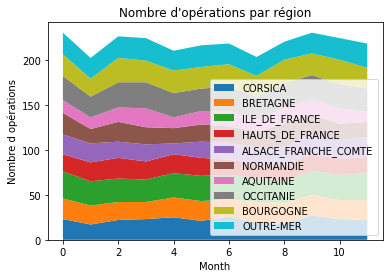

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.stackplot(l_months, dic_regions.values(),
             labels=dic_regions.keys())
ax.legend(loc='lower right')
ax.set_title('Nombre d\'opérations par région')
ax.set_xlabel('Month')
ax.set_ylabel('Nombre d opérations')

plt.show()